# imports and data loading

In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
#import celltypist
import anndata as ad
from scipy import sparse
from anndata import AnnData
import sys  
sys.path.insert(0, '/home/icb/leonie.pohl/masterpraktikum_fibrosis_atlas/source/')
#sys.path.append("/home/icb/leonie.pohl/masterpraktikum_fibrosis_atlas/masterpraktikum_fibrosis_atlas/source/utils.py")
import utils
#import scib

In [7]:
adata = sc.read("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/all_datasets_merged/complete_merged_public_and_galapagos.h5ad")

# QC

In [8]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-"))
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)


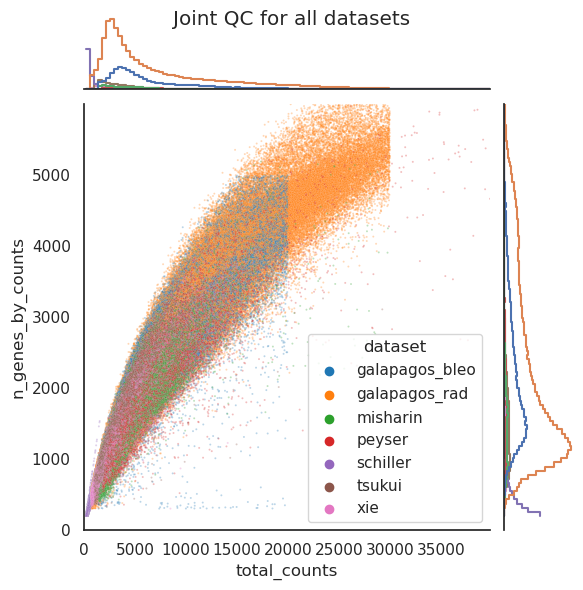

In [9]:
utils.plot_qc_joint(adata, x="total_counts",
                    y='n_genes_by_counts', 
                    hue='dataset', #"dataset",#
                    palette='tab10',
                    marginal_hue="dataset",
                    #x_threshold=(300, 4000), #  total_counts
                    #y_threshold=(0, 17000), # n_genes_by_counts
                    title='Joint QC for all datasets' ) # one for all dataset, colour by dataset 


# Normalization

In [10]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)


In [12]:
log_sum_series = np.ravel(adata.layers["log1p_norm"].sum(1))
dataset_series = adata.obs["dataset"].values
df = pd.DataFrame({
    "log_sum": log_sum_series,
    "dataset": dataset_series
})

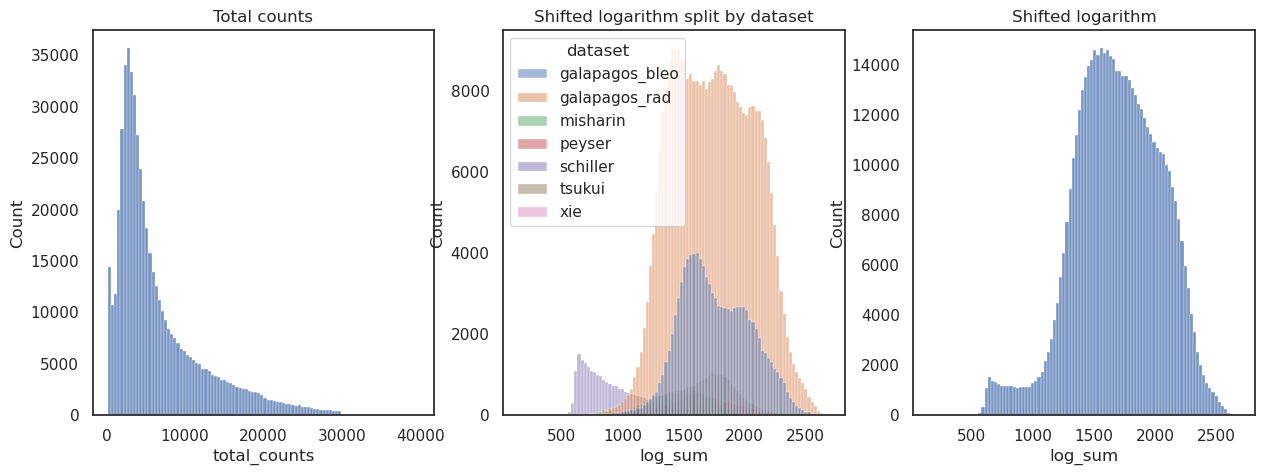

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(df, x="log_sum", bins=100, kde=False, ax=axes[1], hue="dataset")
axes[1].set_title("Shifted logarithm split by dataset")
p3 =  sns.histplot(df, x="log_sum", bins=100, kde=False, ax=axes[2])
axes[2].set_title("Shifted logarithm")
plt.show()

# Feature selection, PCA, UMAP

## feature selection

In [22]:
sc.pp.highly_variable_genes(adata, layer="log1p_norm", min_mean=0.0120, max_mean=3, min_disp=0.5, batch_key="dataset")

In [23]:
plt.rcParams['figure.figsize'] = (5, 5)

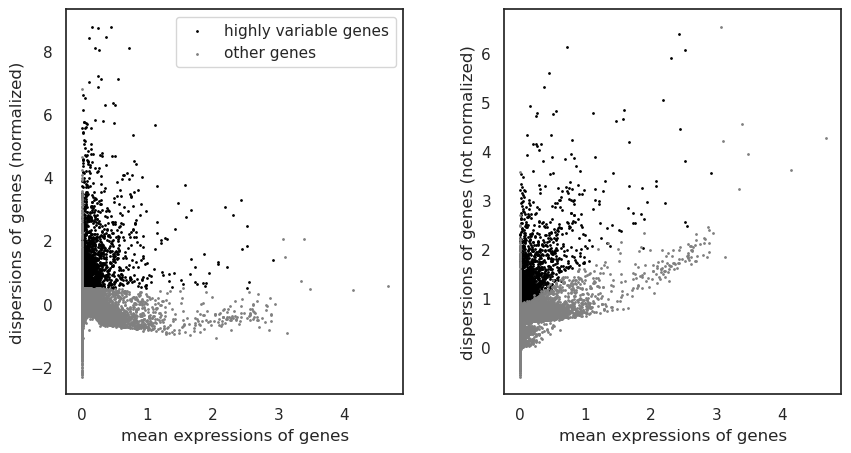

In [24]:
sc.pl.highly_variable_genes(adata)

## PCA 

In [25]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True )

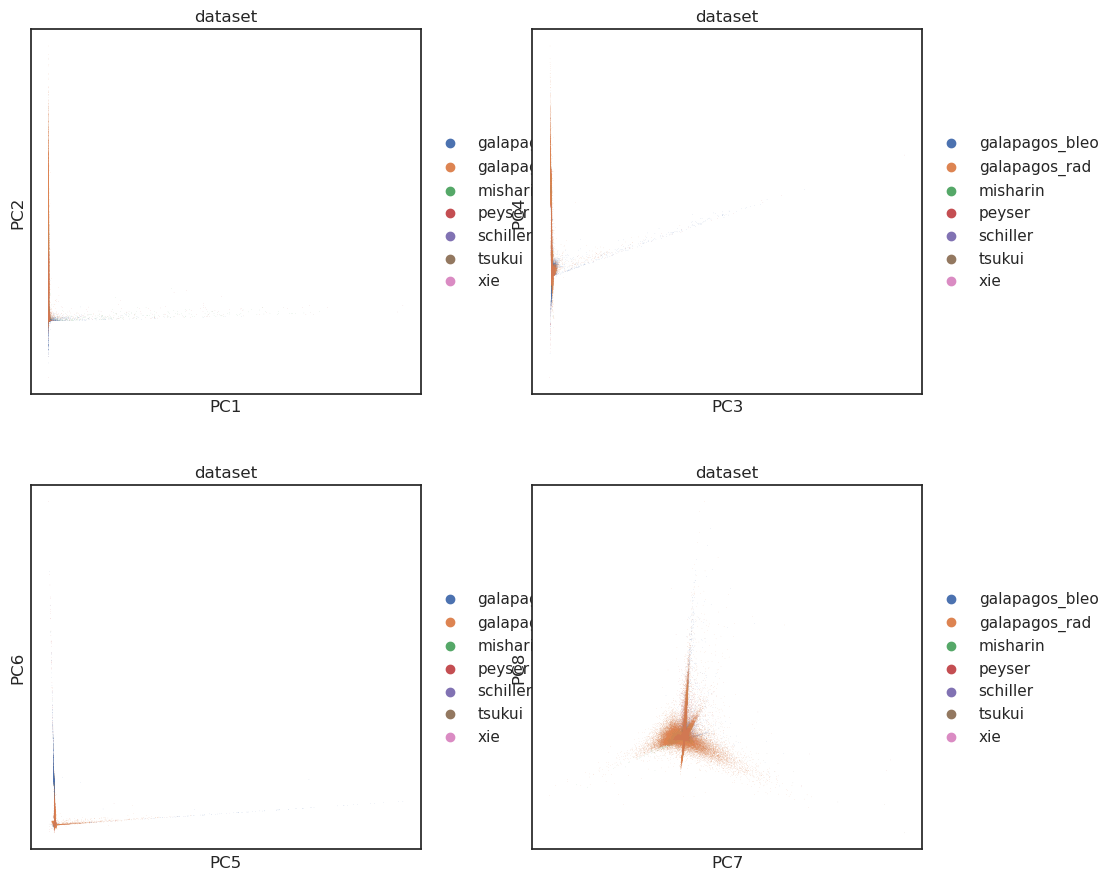

In [33]:
sc.pl.pca(adata, color='dataset', components = ['1,2','3,4','5,6','7,8'], ncols=2)

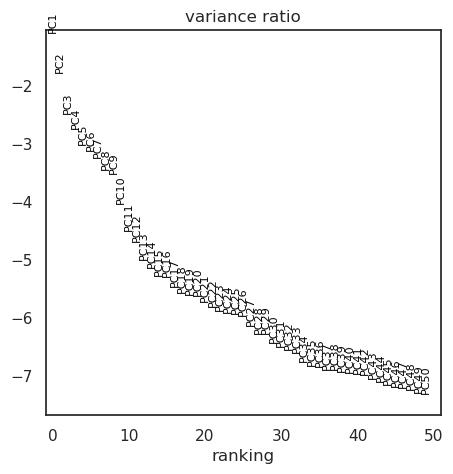

In [29]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50) # später rufe neighbours/UMAP mit verschiedenen PCs auf 


## UMAP 

In [30]:
sc.pp.neighbors(adata,n_pcs = 50, n_neighbors = 20) 


/home/icb/leonie.pohl/mambaforge/envs/scanpy/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/leonie.pohl/mambaforge/envs/scanpy/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/leonie.pohl/mambaforge/envs/scanpy/lib/pyt

In [32]:
sc.tl.umap(adata,  min_dist=0.1)

IOStream.flush timed out
IOStream.flush timed out


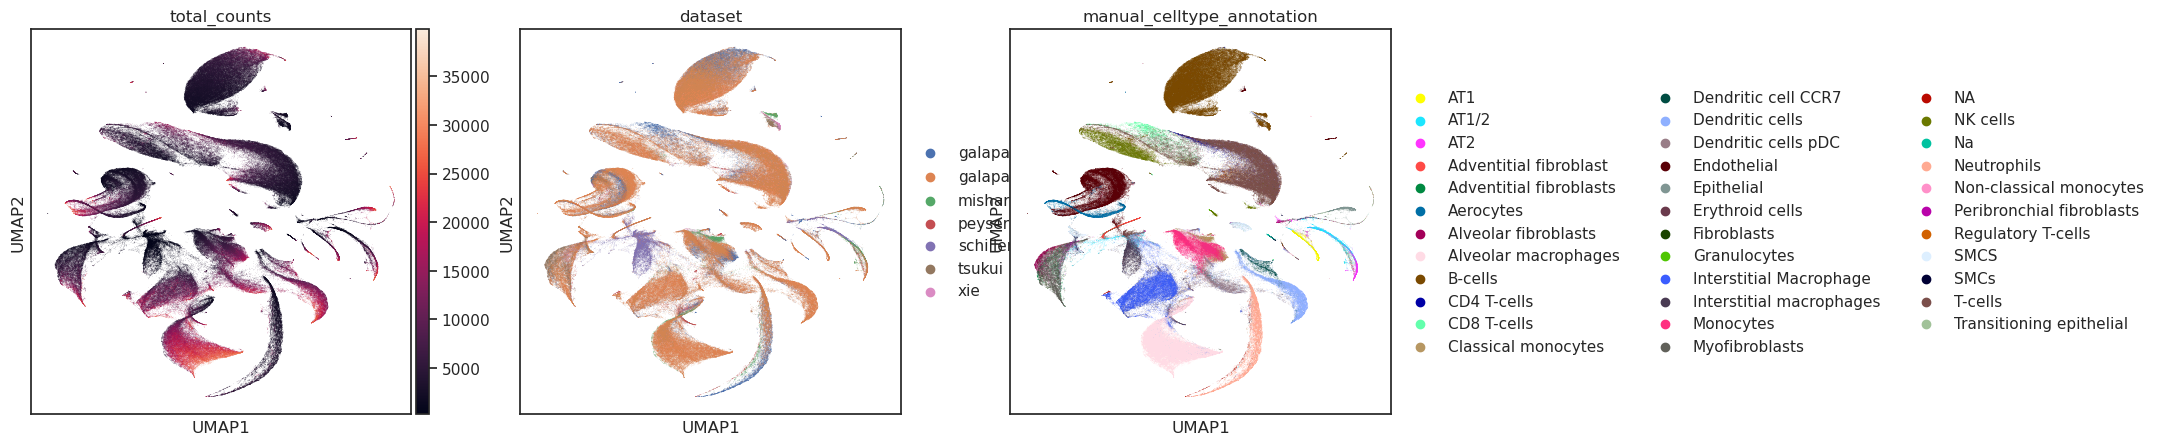

In [34]:
sc.pl.umap(adata, color=["total_counts", "dataset", "manual_celltype_annotation"])

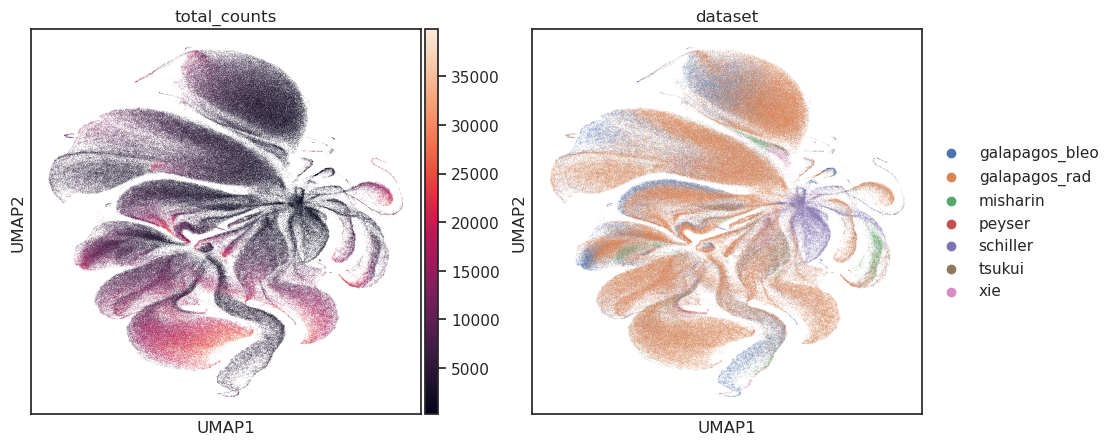

In [31]:
sc.pl.umap(adata, color=["total_counts", "dataset", "manual_celltype_annotation"])

In [35]:
adata.write("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/all_datasets_merged/complete_merged_public_and_galapagos_qc_umap.h5ad")